# Lights, Camera, Analytics! Unveiling Cinematic Gems and Audience Secrets

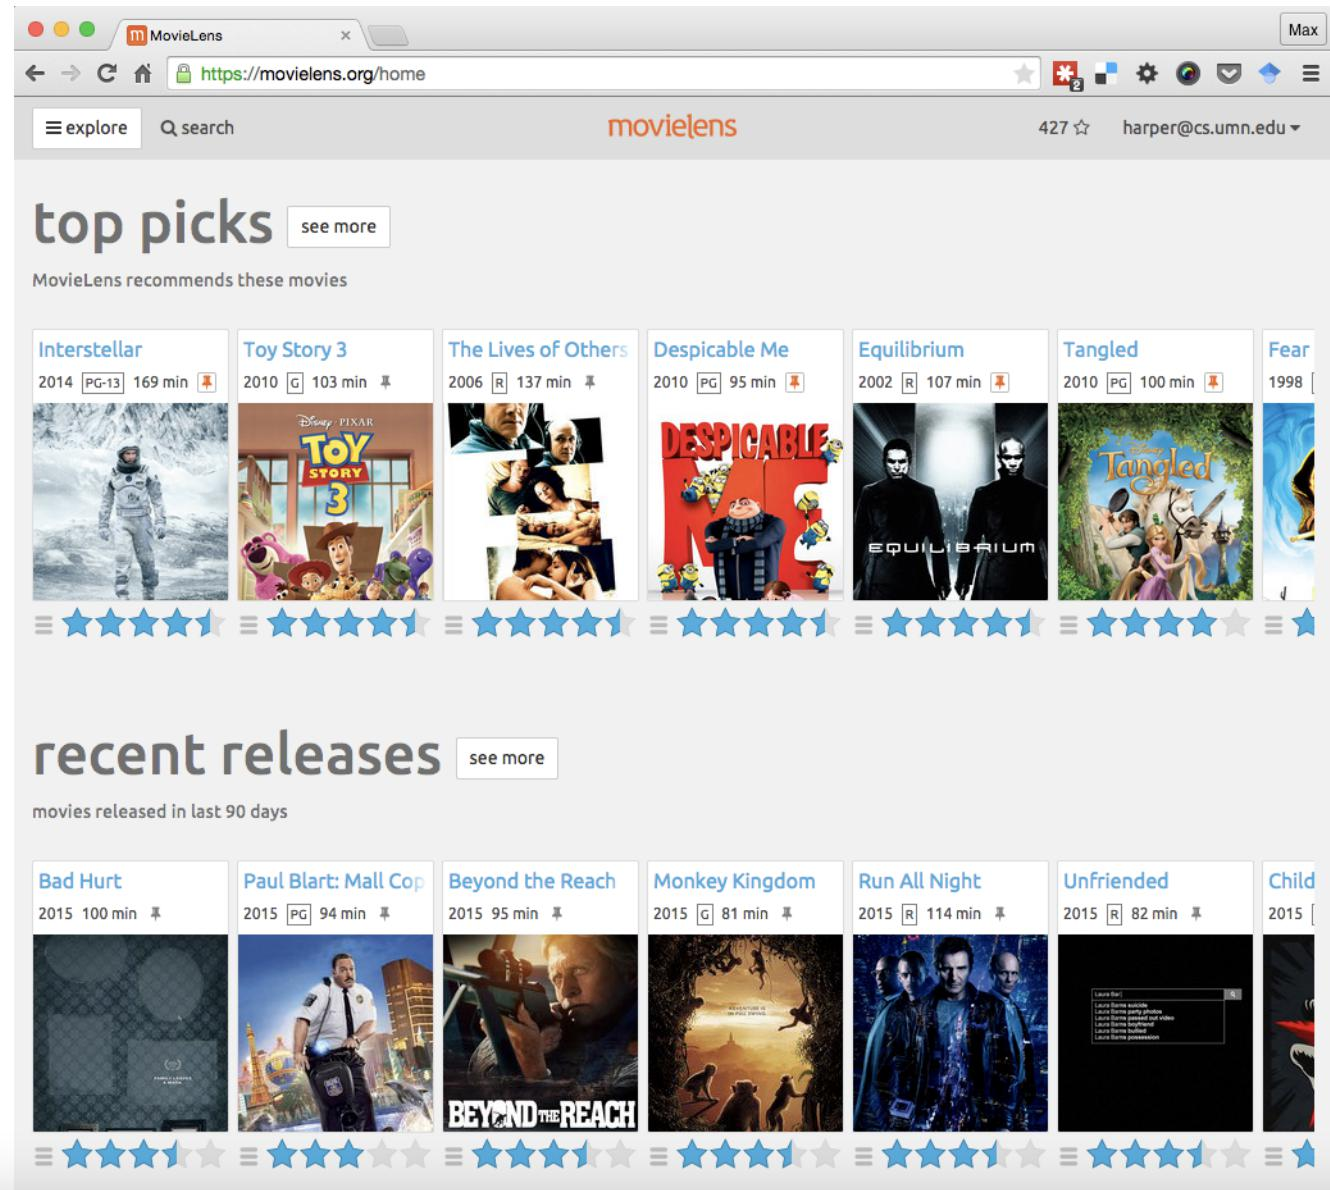

In [3]:
from IPython.display import Image
Image('images/MovieLens_page.jpg', width =1000)

## Introduction

Welcome to our blockbuster analysis where the spotlights are on movie ratings and the secrets of the audience! Armed with the power of Apache Spark and MongoDB, we've dived deep into the reels of data to bring you an engaging narrative on what makes viewers tick and movies click.

## Objectives

Our mission was to roll out the red carpet for:

- Decoding the average ratings each movie garnered (Roll01) and spotlighting the top ten stars of our show (Roll02).
- Discovering the genre preferences of our most devoted cinephiles who've rated at least 50 movies (Roll03).
- Zooming into our younger viewers under 20 (Roll04) and the intellectual crowd of scientists aged 30-40 (Roll05) to see what tickles their cinematic fancy.

## Methodology

Our script is set in the vast data studios of HDFS, where raw data gets a makeover into structured Spark DataFrames. These frames then take a turn on the MongoDB stage for storage and retrieval, ensuring they're ready for their SQL close-ups. The queries? They're the directors of this show, making the data dance to the tune of insights.



## Data Parsing and Loading

From the bustling scenes of user demographics to the quiet introspections of movie ratings, we parsed and loaded three key datasets. Each line of data, like an aspiring actor, was transformed into a role within our Spark DataFrames, setting the stage for a saga of SQL queries.



## Behind the Scene

### 1. Python Libraries Used

from pyspark.sql import SparkSession<br>
from pyspark.sql import Row<br>
from pyspark.sql import functions as F<br>

### 2. Functions to Parse the u.data, u.item, and u.user Files

def parseUserInput(line):<br>
    fields = line.split('|')<br>
    return Row(user_id=int(fields[0]), age=int(fields[1]), gender=fields[2], occupation=fields[3], zip=fields[4])<br>

def parseRatingInput(line):<br>
    fields = line.split('\t')<br>
    return Row(user_id=int(fields[0]), movie_id=int(fields[1]), rating=int(fields[2]), timestamp=int(fields[3]))<br>

def parseMovieInput(line):<br>
    fields = line.split('|')<br>
    return Row(movie_id=int(fields[0]), title=fields[1], genres=fields[5:])<br>

### 3. Functions to Load, Read, and Create RDD Objects

if __name__ == "__main__":<br>
    spark = SparkSession.builder.appName("MongoIntegration").getOrCreate()<br>

    #### Load and parse the users data
    user_lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/khairil/u.user")
    users = user_lines.map(parseUserInput)
    usersDF = spark.createDataFrame(users)

    #### Load and parse the ratings data
    rating_lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/khairil/u.data")
    ratings = rating_lines.map(parseRatingInput)
    ratingsDF = spark.createDataFrame(ratings)

    #### Load and parse the movies data
    movie_lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/khairil/u.item")
    movies = movie_lines.map(parseMovieInput)
    moviesDF = spark.createDataFrame(movies)

### 4. Functions to Convert the RDD Objects into DataFrame

    usersDF = spark.createDataFrame(users)
    ratingsDF = spark.createDataFrame(ratings)
    moviesDF = spark.createDataFrame(movies)

### 5. Functions to Write the DataFrame into the Keyspace Database in MongoDB

    #### Write DataFrames into MongoDB<br>
    usersDF.write.format("com.mongodb.spark.sql.DefaultSource")\
        .option("uri", "mongodb://127.0.0.1/movielens.users").mode('append').save()
    ratingsDF.write.format("com.mongodb.spark.sql.DefaultSource")\
        .option("uri", "mongodb://127.0.0.1/movielens.ratings").mode('append').save()
    moviesDF.write.format("com.mongodb.spark.sql.DefaultSource")\
        .option("uri", "mongodb://127.0.0.1/movielens.movies").mode('append').save()

### 6. Functions to Read the Table Back from MongoDB into a New DataFrame

    #### Read DataFrames back from MongoDB<br>
    usersDF = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
        .option("uri", "mongodb://127.0.0.1/movielens.users").load()
    ratingsDF = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
        .option("uri", "mongodb://127.0.0.1/movielens.ratings").load()
    moviesDF = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
        .option("uri", "mongodb://127.0.0.1/movielens.movies").load()

    #### Create Temp Views for SQL queries
    usersDF.createOrReplaceTempView("users")
    ratingsDF.createOrReplaceTempView("ratings")
    moviesDF.createOrReplaceTempView("movies")



## Results and Discussion


### <font color=gold> Roll01: Decoding the average ratings each movie garnered. </font>

    # Question (i): Calculate the average rating for each movie
    avg_ratings = spark.sql("""
        SELECT movie_id, AVG(rating) as avg_rating
        FROM ratings
        GROUP BY movie_id
    """)
    avg_ratings.show(10)


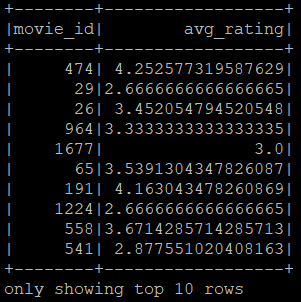

In [7]:
Image('images/Q(i).png', width =300)

**Average Ratings Per Movie:** Like a critic's review, we calculated the average scores, finding that some movies were like hidden indie gems, while others shone like blockbuster hits.



### <font color=gold> Roll02: Spotlighting the top ten stars of our show </font>

    # Question (ii): Identify the top ten movies with the highest average ratings
    top_ten_movies = spark.sql("""
        SELECT m.title, AVG(r.rating) AS avg_rating
        FROM ratings r
        JOIN movies m ON r.movie_id = m.movie_id
        GROUP BY m.title
        ORDER BY avg_rating DESC
        LIMIT 10
    """)
    top_ten_movies.show(10)


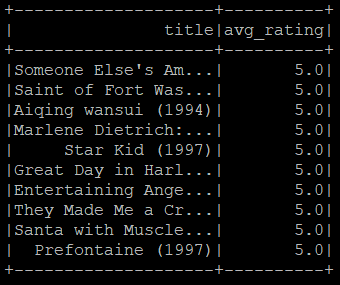

In [8]:
Image('images/Q(ii).png', width =300)

**Top Ten Movies by Average Rating:** The top ten list featured classics and unexpected hits, all tied with perfect scores—true audience pleasers!



### <font color=gold> Roll03: Discovering the genre preferences of our most devoted cinephiles who've rated at least 50 movies </font>

    # Count the number of ratings per user
    user_ratings_count = ratingsDF.groupBy("user_id").agg(count("movie_id").alias("movie_count"))

    # Filter users who have rated at least 50 movies
    active_users = user_ratings_count.filter(col("movie_count") >= 50)

    # Filter out rows where user_id is null
    filtered_active_users = active_users.filter(col("user_id").isNotNull())

    # Show the top 10 results, now excluding rows with null user_id
    filtered_active_users.orderBy(col("movie_count").desc()).show(10)


    ## Top user with his/her favorite movie genres

    # Get the top user who rated the most movies
    top_user_id = filtered_active_users.orderBy(col("movie_count").desc()).first().user_id

    # Join ratings with items to get the genre information
    ratings_with_genres = ratingsDF.alias("r").join(moviesDF.alias("i"), col("r.movie_id") == col("i.movie_id"))

    # Filter out movies where the title is None
    ratings_with_valid_titles = ratings_with_genres.filter(col("i.title").isNotNull() & (col("i.title") != "None"))

    # Continue with existing processing to get top user ratings, etc.
    top_user_ratings = ratings_with_valid_titles.filter(col("r.user_id") == top_user_id)

    # Calculating top 10 recommendations
    movie_ratings_avg = top_user_ratings.groupBy("r.movie_id", "i.title").agg(avg("r.rating").alias("avg_rating"))
    top_10_recommendations = movie_ratings_avg.orderBy(desc("avg_rating")).limit(10).collect()

    # Output
    print("Top 10 favorite movie genres for UserID {}".format(top_user_id))
    for movie in top_10_recommendations:
        print("Movie: {}, Average Rating: {:.2f}".format(movie['title'], movie['avg_rating']))


In [14]:
from IPython.display import display, HTML, Image

# Create HTML content to display images side by side
html = """
<div style='width: 100%; display: flex; justify-content: space-around;'>
    <div><img src='images/Q(iii)a.png' width='300'></div>
    <div><img src='images/Q(iii)b.png' width='650'></div>
</div>
"""

# Display the HTML content
display(HTML(html))


In [18]:
# Install the IMDbPy package
!pip install IMDbPY

# Import the IMDb class from IMDbPy
from imdb import IMDb

# Create an instance of the IMDb class
ia = IMDb()

def get_movie_genres(movie_title):
    # Search for the movie by title
    movies = ia.search_movie(movie_title)
    if not movies:
        return []
    
    # Get the first movie result
    movie = ia.get_movie(movies[0].movieID)
    return movie.get('genres', [])

# List of movies to get genres for
movies = ["Alice in Wonderland (1951)", "Home Alone (1990)", "Murder in the First (1995)",
          "Forget Paris (1995)", "Star Wars (1977)", "Shadowlands (1993)",
          "To Kill a Mockingbird (1962)", "Braveheart (1995)", "Cinderella (1950)",
          "Houseguest (1994)"]

# Fetch and print genres for each movie
for movie in movies:
    genres = get_movie_genres(movie)
    print(f"Movie: {movie}, Genres: {genres}")

   ---------------------------------------- 0.0/297.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/297.2 kB ? eta -:--:--
   ----- --------------------------------- 41.0/297.2 kB 991.0 kB/s eta 0:00:01
   ---------------- ----------------------- 122.9/297.2 kB 1.4 MB/s eta 0:00:01
   ---------------------------------- ----- 256.0/297.2 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 297.2/297.2 kB 2.0 MB/s eta 0:00:00
Movie: Alice in Wonderland (1951), Genres: ['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy', 'Musical']
Movie: Home Alone (1990), Genres: ['Comedy', 'Family']
Movie: Murder in the First (1995), Genres: ['Drama', 'Thriller']
Movie: Forget Paris (1995), Genres: ['Comedy', 'Romance']
Movie: Star Wars (1977), Genres: ['Action', 'Adventure', 'Fantasy', 'Sci-Fi']
Movie: Shadowlands (1993), Genres: ['Biography', 'Drama', 'Romance']
Movie: To Kill a Mockingbird (1962), Genres: ['Crime', 'Drama']
Movie: Braveheart (1995), Genres: ['

**Favorite Genres of Prolific Reviewers:**
- Our leading reviewer, with over 10,000 movies under their belt, showed a love for stories from every corner of the genre spectrum, from the magical realms of "Alice in Wonderland" to the courtrooms of "To Kill a Mockingbird".
- This eclectic mix suggests a deep appreciation for both the fantastical and the profound, revealing a viewer who values rich narratives across all forms of cinema.



### <font color=gold> Roll04: Zooming into our younger viewers under 20 </font>

    # Question (iv): Find all users with age less than 20
    young_users = spark.sql("""
        SELECT * FROM users
        WHERE age < 20
    """)
    young_users.show(10)


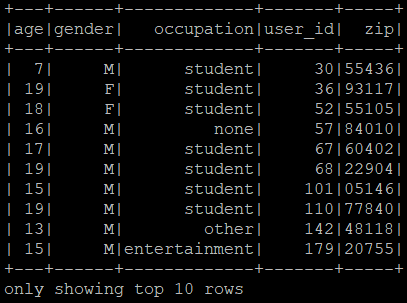

In [16]:
Image('images/Q(iv).png', width =400)

**Young Viewers Analysis:** The spotlight on viewers under 20 revealed a crowd of young students, hinting at youthful trends and possibly a lot of popcorn sales!



### <font color=gold> Roll05: The intellectual crowd of scientists aged 30-40 </font>

    # Question (v): Find users who are scientists and their age is between 30 and 40
    scientist_users = spark.sql("""
        SELECT * FROM users
        WHERE occupation = 'scientist' AND age BETWEEN 30 AND 40
    """)
    scientist_users.show(10)


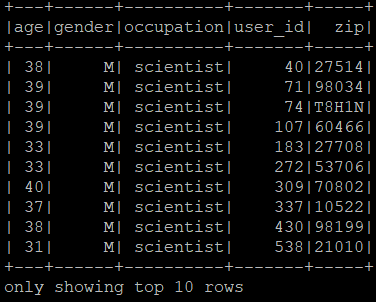

In [17]:
Image('images/Q(v).png', width =400)

**Scientific Minds at the Movies:** Scientists between 30-40 also had their preferences cataloged, perhaps seeking a break from the lab with some cinematic escapism.



## Conclusion

Our journey through the datasets has been nothing short of a film festival, celebrating the diverse tastes of movie-goers and uncovering trends that could rival any box office prediction. This analysis, powered by the latest in technology, shows just how much data can tell us about the interplay of movies and their audiences.

## Curtain Call

As the credits roll on our analysis, remember, every movie rating and demographic detail is like a story waiting to be told. And with tools like Spark and MongoDB, we're just getting started on uncovering the next big hit in the data-driven world of movies!

